In [1]:
# Required Packages
import pandas as pd
import numpy as np
import math
import json

# Display
from IPython.core.display import Image, display
from collections import defaultdict
import progressbar

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# Plots

import seaborn as sns
import matplotlib.pyplot as plt

# sns setting
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":14,"axes.labelsize":12})
sns.set_style("whitegrid")

# plt setting
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

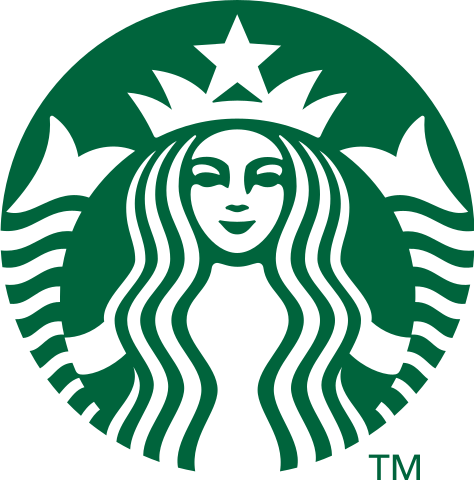

In [2]:
display(Image('https://upload.wikimedia.org/wikipedia/en/thumb/d/d3/Starbucks_Corporation_Logo_2011.svg/474px-Starbucks_Corporation_Logo_2011.svg.png',
              width=300, unconfined=True))

# Starbucks Offer Personalizations

In this article, simulated data that mimics customer behavior on the Starbucks rewards mobile app is used. Starbucks tends to send out offers to users of the mobile app once every few days. These offers are exclusive, that is not all users receive the same offer. An offer can contain a  discount for their products or sometimes BOGO (buy one get one free). These offers have a validity period before the offer expires. The article here is inspired by a [towardsdatascience.com](https://towardsdatascience.com/using-starbucks-app-user-data-to-predict-effective-offers-20b799f3a6d5) article.


For preprocessing and initial data analysis see the first part of this article [here](https://hatefdastour.github.io/portfolio/machine_learning/Starbucks_Offer_Personalizations_Preprocessing_and_Analyzing.html).

### Table of contents
* [The Problem of Interest](#The-Problem-of-Interest)
* [Effective Offers vs. Ineffective Offers](#Effective-Offers-vs.-Ineffective-Offers)
    * [Effective Offers](#Effective-Offers)
    * [Ineffective Offers](#Ineffective-Offers)
* [Creating a General Dataframe](#Creating-a-General-Dataframe)
* [Modeling](#Modeling)
	* [Determining the best offer type](#Determining-the-best-offer-type)
	* [Important Features](#Important-Features)
	* [Feature Difference by Offer Combination](#Feature-Difference-by-Offer-Combination)
	* [Predicting the most suitable offer type for a customer](#Predicting-the-most-suitable-offer-type-for-a-customer)

#### Loading the preprocessed data

In [3]:
portfolio = pd.read_csv('Data/Clean_portfolio.csv')
profile = pd.read_csv('Data/Clean_profile.csv')
transcript = pd.read_csv('Data/Clean_transcript.csv')
transcript_portfolio = pd.read_csv('Data/Clean_transcript_portfolio.csv')

## The Problem of Interest

### Effective Offers vs. Ineffective Offers

#### Effective Offers
An offer is considered an <font color='blue'>effective offers </font> if a customer receives an offer, and then view the received offer, and finally, complete a transaction either <font color='red'>BOGO and Discount Offers</font>, or complete a transaction using <font color='red'>Informational Offers</font> within the period those offers are valid.
#### Ineffective Offers
An offer is <font color='blue'>ineffective offers </font> if it is not effective. However, this can be analyzed futher.

Consider the following diagram:

**Effective Offers**:

* Offer Received
    * Offer Viewed
        * Transaction
            * Offer Completed (BOGO and Discount Offers)
            * Offer Completed (Informational Offers - transactions must happen within the period those offers are valid)
                                   
**Ineffective Offers**:

* Offer Received
    * No Action Happend
        * no Transaction Happened
        * Offer not Viewed
    * Offer not Viewed
        * Offer not Viewed
            * Transaction
                * Offer Viewed
* Offer not Received
    * Transaction 
    
The object of the exercise here is to predict the most suitable offer type that is needed to be sent out to each customer.  In doing so, we need to combine the data (*Portfolio Data*, *Profile Data*, and *Transcript Data*) to build a general database that provides a summary of each user's transactional behaviors.

## Creating a General Dataframe

In this section, we create a general dataframe. First, let's introduce the new parameters (columns of our new dataframe). First, we can group the number of offers that a person received.

| New Parameters | Full Parameters name | Description |
|----------------|------------------------------|----------------------------------------------------------|
| BOGO_Offer_Rec | BOGO Offer Received | The number of BOGO offer received |
| Disc_Offer_Rec | Discount Offer Received | The number of Discoun offer received |
| Info_Offer_Rec | Informational Offer Received | The number of Informational offer received |

In [4]:
Temp = transcript_portfolio[transcript_portfolio['Event']=='offer received']
Temp = Temp.groupby(['Person','Offer_Type'])['Offer_Type'].agg('count').unstack(level=-1)
# Creating a user data dataframe
# Assigning profile IDs as index of the new dataframe
user_data = pd.DataFrame(index = profile['ID'])
# adding Temp to this dataframe
user_data = user_data.join(Temp)
del Temp
# renaming
user_data.rename(columns={'bogo':'BOGO_Offer_Rec',
                          'discount':'Disc_Offer_Rec',
                          'informational':'Info_Offer_Rec'},inplace=True)
user_data.head()

BOGO_Offer_Rec  Disc_Offer_Rec  \
ID                                                                 
68be06ca386d4c31939f3a4f0e3dd783             NaN             5.0   
0610b486422d4921ae7d2bf64640c50b             1.0             NaN   
38fe809add3b4fcf9315a9694bb96ff5             1.0             NaN   
78afa995795e4d85b5d9ceeca43f5fef             3.0             NaN   
a03223e636434f42ac4c3df47e8bac43             NaN             3.0   

                                  Info_Offer_Rec  
ID                                                
68be06ca386d4c31939f3a4f0e3dd783             NaN  
0610b486422d4921ae7d2bf64640c50b             1.0  
38fe809add3b4fcf9315a9694bb96ff5             1.0  
78afa995795e4d85b5d9ceeca43f5fef             1.0  
a03223e636434f42ac4c3df47e8bac43             2.0

As can be seen, not all customers received all offers. Let's investigate this a bit further. Since we have three columns (for the three offers), if we have **NaN** greater than 2, then it means that the customers haven't received any offers!

In [5]:
no_offer = user_data.isnull().sum(axis=1)
# Creating a list
no_offer_list=list(no_offer[no_offer>2].index)
# Print
print ('users never received any offers = %i' % no_offer[no_offer>2].count())

users never received any offers = 6


We can see that **six** users never received any offers!

We can test the results. For example, for the first user from **no_offer_list**, we have

In [6]:
transcript_portfolio[transcript_portfolio['Person'] == no_offer_list[0]]

Person        Event  Time  Amount  \
69477   c6e579c6821c41d1a7a6a9cf936e91bb  transaction   174    0.65   
87239   c6e579c6821c41d1a7a6a9cf936e91bb  transaction   222    1.91   
163610  c6e579c6821c41d1a7a6a9cf936e91bb  transaction   408    1.25   
243317  c6e579c6821c41d1a7a6a9cf936e91bb  transaction   570    3.14   

        Reward_Received Offer_ID  Reward_Defined  Difficulty  Duration  \
69477               NaN      NaN             NaN         NaN       NaN   
87239               NaN      NaN             NaN         NaN       NaN   
163610              NaN      NaN             NaN         NaN       NaN   
243317              NaN      NaN             NaN         NaN       NaN   

       Offer_Type  Email  Mobile  Social  Web  
69477         NaN    NaN     NaN     NaN  NaN  
87239         NaN    NaN     NaN     NaN  NaN  
163610        NaN    NaN     NaN     NaN  NaN  
243317        NaN    NaN     NaN     NaN  NaN

In [7]:
del no_offer, no_offer_list

It can be seen that the customer (person column) has all **NaN** columns!

Adding more columns to **user_data** dataframe, we can introduce new parameters.

| New Parameters | Full Parameters name | Description |
|----------------|----------------------------|--------------------------------------------------------------------------------------|
| Tot_Tran_Cnt | Total Transaction Count | Whether or not an offer incentivized a transaction |
| Tot_Tran_Amnt | Total Transaction Amount | Total transaction amount |
| Tot_Rewards_Rec | Total Rewards Received | The number of received rewards  from an offer type |
| Ave_Tran_Amnt | Average Transaction Amount | Total transaction amount (TTA) / Total transaction count (TTC) |

### Total Transaction Count

In [8]:
# Selecting those who had transactions
Temp = transcript_portfolio[transcript_portfolio['Event'] =='transaction']
# Group by Event for each Person (Total Transactions per person)
Temp = Temp.groupby(['Person'])['Event'].agg({'Tot_Tran_Cnt':'count'})
# Addding it to user_data
user_data = user_data.join(Temp)
del Temp
user_data.head()

BOGO_Offer_Rec  Disc_Offer_Rec  \
ID                                                                 
68be06ca386d4c31939f3a4f0e3dd783             NaN             5.0   
0610b486422d4921ae7d2bf64640c50b             1.0             NaN   
38fe809add3b4fcf9315a9694bb96ff5             1.0             NaN   
78afa995795e4d85b5d9ceeca43f5fef             3.0             NaN   
a03223e636434f42ac4c3df47e8bac43             NaN             3.0   

                                  Info_Offer_Rec  Tot_Tran_Cnt  
ID                                                              
68be06ca386d4c31939f3a4f0e3dd783             NaN           9.0  
0610b486422d4921ae7d2bf64640c50b             1.0           3.0  
38fe809add3b4fcf9315a9694bb96ff5             1.0           6.0  
78afa995795e4d85b5d9ceeca43f5fef             1.0           7.0  
a03223e636434f42ac4c3df47e8bac43             2.0           3.0

### Total Transaction Amount

In [9]:
# Selecting those who had transactions
Temp = transcript_portfolio[transcript_portfolio['Event'] =='transaction']
# Group by Event for each Person (Total Transactions per person)
Temp = Temp.groupby(['Person'])['Amount'].agg({'Tot_Tran_Amnt':'sum'})
# Addding it to user_data
user_data = user_data.join(Temp)
del Temp
user_data.head()

BOGO_Offer_Rec  Disc_Offer_Rec  \
ID                                                                 
68be06ca386d4c31939f3a4f0e3dd783             NaN             5.0   
0610b486422d4921ae7d2bf64640c50b             1.0             NaN   
38fe809add3b4fcf9315a9694bb96ff5             1.0             NaN   
78afa995795e4d85b5d9ceeca43f5fef             3.0             NaN   
a03223e636434f42ac4c3df47e8bac43             NaN             3.0   

                                  Info_Offer_Rec  Tot_Tran_Cnt  Tot_Tran_Amnt  
ID                                                                             
68be06ca386d4c31939f3a4f0e3dd783             NaN           9.0          20.40  
0610b486422d4921ae7d2bf64640c50b             1.0           3.0          77.01  
38fe809add3b4fcf9315a9694bb96ff5             1.0           6.0          14.30  
78afa995795e4d85b5d9ceeca43f5fef             1.0           7.0         159.27  
a03223e636434f42ac4c3df47e8bac43             2.0           3.0           4.65

### Total Reward Received

In [10]:
# Group by Event for each Person (Total Transactions per person)
Temp = transcript_portfolio.groupby(['Person'])['Reward_Received'].agg({'Tot_Rewards_Rec':'sum'})
# Addding it to user_data
user_data = user_data.join(Temp)
del Temp
user_data.head()

BOGO_Offer_Rec  Disc_Offer_Rec  \
ID                                                                 
68be06ca386d4c31939f3a4f0e3dd783             NaN             5.0   
0610b486422d4921ae7d2bf64640c50b             1.0             NaN   
38fe809add3b4fcf9315a9694bb96ff5             1.0             NaN   
78afa995795e4d85b5d9ceeca43f5fef             3.0             NaN   
a03223e636434f42ac4c3df47e8bac43             NaN             3.0   

                                  Info_Offer_Rec  Tot_Tran_Cnt  Tot_Tran_Amnt  \
ID                                                                              
68be06ca386d4c31939f3a4f0e3dd783             NaN           9.0          20.40   
0610b486422d4921ae7d2bf64640c50b             1.0           3.0          77.01   
38fe809add3b4fcf9315a9694bb96ff5             1.0           6.0          14.30   
78afa995795e4d85b5d9ceeca43f5fef             1.0           7.0         159.27   
a03223e636434f42ac4c3df47e8bac43             2.0           3.0           4.65   

                                  Tot_Rewards_Rec  
ID                                                 
68be06ca386d4c31939f3a4f0e3dd783              5.0  
0610b486422d4921ae7d2bf64640c50b              5.0  
38fe809add3b4fcf9315a9694bb96ff5              0.0  
78afa995795e4d85b5d9ceeca43f5fef             20.0  
a03223e636434f42ac4c3df47e8bac43              0.0

### Average Transaction Amount

$$Total~Transaction~Amount=\frac{Total~Transaction~Amount}{Total~Transaction~Count}$$

In [11]:
user_data['Ave_Tran_Amnt'] = round(user_data.Tot_Tran_Amnt/user_data.Tot_Tran_Cnt,3)
user_data.head()

BOGO_Offer_Rec  Disc_Offer_Rec  \
ID                                                                 
68be06ca386d4c31939f3a4f0e3dd783             NaN             5.0   
0610b486422d4921ae7d2bf64640c50b             1.0             NaN   
38fe809add3b4fcf9315a9694bb96ff5             1.0             NaN   
78afa995795e4d85b5d9ceeca43f5fef             3.0             NaN   
a03223e636434f42ac4c3df47e8bac43             NaN             3.0   

                                  Info_Offer_Rec  Tot_Tran_Cnt  Tot_Tran_Amnt  \
ID                                                                              
68be06ca386d4c31939f3a4f0e3dd783             NaN           9.0          20.40   
0610b486422d4921ae7d2bf64640c50b             1.0           3.0          77.01   
38fe809add3b4fcf9315a9694bb96ff5             1.0           6.0          14.30   
78afa995795e4d85b5d9ceeca43f5fef             1.0           7.0         159.27   
a03223e636434f42ac4c3df47e8bac43             2.0           3.0           4.65   

                                  Tot_Rewards_Rec  Ave_Tran_Amnt  
ID                                                                
68be06ca386d4c31939f3a4f0e3dd783              5.0          2.267  
0610b486422d4921ae7d2bf64640c50b              5.0         25.670  
38fe809add3b4fcf9315a9694bb96ff5              0.0          2.383  
78afa995795e4d85b5d9ceeca43f5fef             20.0         22.753  
a03223e636434f42ac4c3df47e8bac43              0.0          1.550

Now we add more parameters to the **user_data** dataframe.

| New Parameters        | Full Parameters name                   | Description                                                                                               |
|-----------------------|----------------------------------------|-----------------------------------------------------------------------------------------------------------|
| Tran_Comp_NO_off      | Transactions Count without any Offers  | The number of transactions for a user completes without an offer                                          |
| Tran_Comp_off         | Transactions Count with Offers         | The number of transactions for a user completes with an offer                                             |
| Tran_Amnt_NO_off      | Transactions Amount without any Offers | The amount of transactions for a user completes without an offer                                          |
| Tran_Amnt_off         | Transactions Amount with Offers        | The amount of transactions for a user completes with an offer                                             |
| Offer_Tran_Cnt_Ratio  | Offer Transactions Count Ratio         | Transaction count incentivized by offer / Total number of transactions - TC_Of/TTC                        |
| Offer_Tran_Amnt_Ratio | Offer Transactions Amount Ratio        | Transaction amount incentivized by offer / Total amount of transactions - TA_Of/TTA                       |
| Offer_Comp_View_Ratio | Offer Completed View Ratio             | The number of offer completed / the number of offer viewed                                                |
| Offer_Comp_Rec_Ratio  | Offer Completed Receive Ratio          | The number of offers completed/ the number of offers received                                             |
| Tran_Amnt_per_Offer   | Transactions Amount per Offer          | The total transaction amount with offer/ Total number of transactions with an offer                       |
| Reward_per_Offer      | Reward per Offer                       | Total rewards received / the number of offer completed                                                    |
| BOGO_Comp             | BOGO Completed                         | The number of offer completed for BOGO offer after viewing the BOGO offer                                 |
| Disc_Comp             | Discount Completed                     | The number of offer completed for Discount offer after viewing the Discount offer                         |
| Info_Comp             | Information Completed                  | The number of offer completed for Information offer after viewing the Information offer                   |
| BOGO_Conv             | BOGO offer conversion rate             | The number of BOGO offers completed / The number of BOGO offer received - BOGO_Comp/BOGO_OR               |
| Info_Conv             | Information offer conversion rate      | The number of Information offers completed / The number of Information offer received - Info_Comp/Info_OR |
| Disc_Conv             | Discount offer conversion rate         | The number of Discount offers completed / The number of Discount offer received - Disc_Comp/Disc_OR       |

Given the fact that **there is no explicit offer conversion** for the parameters that just being introduced. We need to use **nested loops** based on the number of offer completed transaction and transactions amount from the offer conversion.

We can create a function, **user_record** that takes a user_id and gives all user records as a DataFrame. Then, this function is used to investigate the data based on assumptions that were made at the beginning of this section.

In [12]:
user_record = lambda user_id: transcript_portfolio[transcript_portfolio['Person'] == user_id].reset_index(drop=True)

For example we can run:

In [13]:
user_record('68be06ca386d4c31939f3a4f0e3dd783')

Person            Event  Time  Amount  \
0   68be06ca386d4c31939f3a4f0e3dd783   offer received   168     NaN   
1   68be06ca386d4c31939f3a4f0e3dd783     offer viewed   216     NaN   
2   68be06ca386d4c31939f3a4f0e3dd783   offer received   336     NaN   
3   68be06ca386d4c31939f3a4f0e3dd783     offer viewed   348     NaN   
4   68be06ca386d4c31939f3a4f0e3dd783      transaction   360    0.35   
5   68be06ca386d4c31939f3a4f0e3dd783   offer received   408     NaN   
6   68be06ca386d4c31939f3a4f0e3dd783     offer viewed   408     NaN   
7   68be06ca386d4c31939f3a4f0e3dd783      transaction   414    0.74   
8   68be06ca386d4c31939f3a4f0e3dd783      transaction   444    1.89   
9   68be06ca386d4c31939f3a4f0e3dd783   offer received   504     NaN   
10  68be06ca386d4c31939f3a4f0e3dd783     offer viewed   504     NaN   
11  68be06ca386d4c31939f3a4f0e3dd783      transaction   510    5.04   
12  68be06ca386d4c31939f3a4f0e3dd783      transaction   534    0.38   
13  68be06ca386d4c31939f3a4f0e3dd783      transaction   552    2.12   
14  68be06ca386d4c31939f3a4f0e3dd783  offer completed   552     NaN   
15  68be06ca386d4c31939f3a4f0e3dd783  offer completed   552     NaN   
16  68be06ca386d4c31939f3a4f0e3dd783   offer received   576     NaN   
17  68be06ca386d4c31939f3a4f0e3dd783     offer viewed   582     NaN   
18  68be06ca386d4c31939f3a4f0e3dd783      transaction   606    4.61   
19  68be06ca386d4c31939f3a4f0e3dd783      transaction   630    0.06   
20  68be06ca386d4c31939f3a4f0e3dd783      transaction   696    5.21   

    Reward_Received                          Offer_ID  Reward_Defined  \
0               NaN  2906b810c7d4411798c6938adc9daaa5             2.0   
1               NaN  2906b810c7d4411798c6938adc9daaa5             2.0   
2               NaN  0b1e1539f2cc45b7b9fa7c272da2e1d7             5.0   
3               NaN  0b1e1539f2cc45b7b9fa7c272da2e1d7             5.0   
4               NaN                               NaN             NaN   
5               NaN  fafdcd668e3743c1bb461111dcafc2a4             2.0   
6               NaN  fafdcd668e3743c1bb461111dcafc2a4             2.0   
7               NaN                               NaN             NaN   
8               NaN                               NaN             NaN   
9               NaN  2298d6c36e964ae4a3e7e9706d1fb8c2             3.0   
10              NaN  2298d6c36e964ae4a3e7e9706d1fb8c2             3.0   
11              NaN                               NaN             NaN   
12              NaN                               NaN             NaN   
13              NaN                               NaN             NaN   
14              2.0  fafdcd668e3743c1bb461111dcafc2a4             2.0   
15              3.0  2298d6c36e964ae4a3e7e9706d1fb8c2             3.0   
16              NaN  fafdcd668e3743c1bb461111dcafc2a4             2.0   
17              NaN  fafdcd668e3743c1bb461111dcafc2a4             2.0   
18              NaN                               NaN             NaN   
19              NaN                               NaN             NaN   
20              NaN                               NaN             NaN   

    Difficulty  Duration Offer_Type  Email  Mobile  Social  Web  
0         10.0       7.0   discount    1.0     1.0     0.0  1.0  
1         10.0       7.0   discount    1.0     1.0     0.0  1.0  
2         20.0      10.0   discount    1.0     0.0     0.0  1.0  
3         20.0      10.0   discount    1.0     0.0     0.0  1.0  
4          NaN       NaN        NaN    NaN     NaN     NaN  NaN  
5         10.0      10.0   discount    1.0     1.0     1.0  1.0  
6         10.0      10.0   discount    1.0     1.0     1.0  1.0  
7          NaN       NaN        NaN    NaN     NaN     NaN  NaN  
8          NaN       NaN        NaN    NaN     NaN     NaN  NaN  
9          7.0       7.0   discount    1.0     1.0     1.0  1.0  
10         7.0       7.0   discount    1.0     1.0     1.0  1.0  
11         NaN       NaN        NaN    NaN     NaN     NaN  NaN  
12

and get all records of '68be06ca386d4c31939f3a4f0e3dd783'

### Creating a Dictionary

**Note**: This might take some time to process!

In [14]:
# Creating an empty dictionary (list)
Person_Effective_Offer = defaultdict(list)

# Creating a list of 'offer_id' for only 'BOGO' and 'Discount' offer types
Bogo_Discount_Offer_IDS = portfolio[portfolio['Offer_Type'].isin(['bogo', 'discount'])]['Offer_ID'].values

# Person's Transactions from viewed offers (Dictionary)
Person_Off_Trans = defaultdict(lambda: defaultdict(float))

# initial value for Counter
Counter = 0
Progress_Bar = progressbar.ProgressBar(maxval=user_data.shape[0], widgets=[progressbar.Bar('*', '[', ']'),
                                                                           progressbar.Percentage()])
# Starting the Progress Bar
Progress_Bar.start()

# The outer loop for ALL users in the user_data
for user_id in user_data.index:
    
    Counter+=1 
    Progress_Bar.update(Counter)
    
    # getting the records for the current user
    Transaction_Received = user_record(user_id)
    # The index of the received offers
    Offer_Received_Index = Transaction_Received[Transaction_Received['Event'] == 'offer received'].index.values
    # All transactions for the current user
    transactions = Transaction_Received[Transaction_Received['Event'] == 'transaction']
    # Transaction offer index set as empty (for the inside of the inner loop)
    Transaction_Offer_Index = []
    # The iner loop for the received offers indeces
    for R_ind in Offer_Received_Index:
        # offer id corresponding to the index
        offer_id = Transaction_Received.loc[R_ind, 'Offer_ID']
        # offer validity time (convert days to hours using 24 as a multiplier)
        Offer_Valid_For = int(portfolio[portfolio['Offer_ID'] == offer_id]['Duration']) * 24
        # offer start time
        Offer_Start = Transaction_Received.loc[R_ind, 'Time']
        # offer end time = offer start time + offer validity time
        Offer_End = Offer_Start + Offer_Valid_For
        # viewed offers (within the offer validity interval)
        viewed = Transaction_Received[(Transaction_Received['Offer_ID'] == offer_id) &
                           (Transaction_Received['Event'] == 'offer viewed') &
                           (Transaction_Received['Time'] >= Offer_Start) &
                           (Transaction_Received['Time'] <= Offer_End)]
        # only if "viewed offers" is not empty
        if viewed.shape[0] >0 :
            # add one to the person's viewed offer column 'Offer_View'
            Person_Off_Trans[user_id]['Offer_View'] += 1
            # offer_id from the above list 'Bogo_Discount_Offer_IDS'
            if offer_id in Bogo_Discount_Offer_IDS:
                # checking whether a viewed offer has been completed (within the offer validity interval)
                completed = Transaction_Received[(Transaction_Received['Offer_ID'] == offer_id) &
                           (Transaction_Received['Event'] == 'offer completed') &
                           (Transaction_Received['Time'] >= Offer_Start) &
                           (Transaction_Received['Time'] <= Offer_End)]
                # only if "completed offers" is not zero (has some enteries)
                if completed.shape[0] > 0 :
                    View_Ind = viewed.index[0]
                    comp_ind = completed.index[0]
                    Conv_Offer_Type = completed['Offer_Type'].values[0]
                    Offer_Difficulty = completed['Difficulty'].values[0]
                    # if the number of viewed offers is less than the number of completed offers
                    if View_Ind < comp_ind:
                        Person_Off_Trans[user_id]['offer_comp'] += 1
                        Person_Off_Trans[user_id][Conv_Offer_Type] += 1
                        BOGO_Disc_Trans = transactions.loc[View_Ind:comp_ind]['Amount'].sum()
                        Person_Off_Trans[user_id]['Offer_Trans_Amnt'] += BOGO_Disc_Trans
                        Person_Off_Trans[user_id]['Offer_Difficulty'] += Offer_Difficulty 
                        
                        if offer_id not in Person_Effective_Offer[user_id]:
                            Person_Effective_Offer[user_id].append(offer_id)
                    
            else:
                View_Time = viewed.iloc[0]['Time']
                # add one to the person's viewed offer column 'Offer_View'
                Person_Off_Trans[user_id]['Offer_View'] += 1
                # checking whether a viewed offer has been completed (within the offer validity interval)
                Info_Trans = Transaction_Received[(Transaction_Received['Event'] == 'transaction') &
                                       (Transaction_Received['Time'] >= View_Time) &
                                       (Transaction_Received['Time'] <= Offer_End)]
                # only if "Info_Trans" is not zero (has some enteries)
                if Info_Trans.shape[0] > 0:
                    Person_Off_Trans[user_id]['offer_comp'] += 1                    
                    Info_Tran_Amt = Info_Trans['Amount'].sum()
                    Person_Off_Trans[user_id]['Offer_Trans_Amnt'] += Info_Tran_Amt
                    Person_Off_Trans[user_id]['Informational'] +=1
                    if offer_id not in Person_Effective_Offer[user_id]:
                        Person_Effective_Offer[user_id].append(offer_id)
# End of the seraching process
Progress_Bar.finish()

[*************************************************************************]100%


In [15]:
# deleting unnecessary variables
del Progress_Bar, Transaction_Received, Offer_Received_Index, transactions, Transaction_Offer_Index
del offer_id, completed, View_Ind, comp_ind, Conv_Offer_Type, Offer_Difficulty
del BOGO_Disc_Trans, Person_Effective_Offer, View_Time, Info_Trans

Once the searching process has been completed, we can convert the output to a data frame.

In [16]:
# converting the dictionary from the above searching process into data frame
Person_Off_Trans_df = pd.DataFrame.from_dict(Person_Off_Trans, orient = 'index')
# 'comp' stands for completed!
Person_Off_Trans_df = Person_Off_Trans_df.rename(columns={'bogo':'BOGO_comp',
                                                          'discount':'Disc_comp',
                                                          'Informational':'Info_comp'})

In [17]:
# saving as a CSV file
Person_Off_Trans_df.to_csv (r'Data\Person_Off_Trans.csv', header=True)
# saving as a MS Excel file
Person_Off_Trans_df.to_excel(r'Data\Person_Off_Trans.xlsx', header=True)

The output dataframe:

In [18]:
Person_Off_Trans_df.head()

Offer_View  offer_comp  Disc_comp  \
68be06ca386d4c31939f3a4f0e3dd783         5.0         2.0        2.0   
38fe809add3b4fcf9315a9694bb96ff5         1.0         NaN        NaN   
78afa995795e4d85b5d9ceeca43f5fef         5.0         3.0        NaN   
a03223e636434f42ac4c3df47e8bac43         5.0         NaN        NaN   
e2127556f4f64592b11af22de27a7932         3.0         2.0        1.0   

                                  Offer_Trans_Amnt  Offer_Difficulty  \
68be06ca386d4c31939f3a4f0e3dd783             17.71              17.0   
38fe809add3b4fcf9315a9694bb96ff5               NaN               NaN   
78afa995795e4d85b5d9ceeca43f5fef             91.00              15.0   
a03223e636434f42ac4c3df47e8bac43               NaN               NaN   
e2127556f4f64592b11af22de27a7932             36.84              15.0   

                                  BOGO_comp  Info_comp  
68be06ca386d4c31939f3a4f0e3dd783        NaN        NaN  
38fe809add3b4fcf9315a9694bb96ff5        NaN        NaN  
78afa995795e4d85b5d9ceeca43f5fef        2.0        1.0  
a03223e636434f42ac4c3df47e8bac43        NaN        NaN  
e2127556f4f64592b11af22de27a7932        1.0        NaN

Now, turning all **NaN** values in 'bogo_offer', 'discount_offer' and 'information_offer' into zero and ones. One if the value is not not **NaN** and zero for **NaN** values.

In [19]:
Person_Off_Trans_df['BOGO_offer'] = Person_Off_Trans_df['BOGO_comp'].apply(lambda x: 0 if np.isnan(x) else 1)
Person_Off_Trans_df['Disc_offer'] = Person_Off_Trans_df['Disc_comp'].apply(lambda x: 0 if np.isnan(x) else 1)
Person_Off_Trans_df['Info_offer'] = Person_Off_Trans_df['Info_comp'].apply(lambda x: 0 if np.isnan(x) else 1)
Person_Off_Trans_df.head()

Offer_View  offer_comp  Disc_comp  \
68be06ca386d4c31939f3a4f0e3dd783         5.0         2.0        2.0   
38fe809add3b4fcf9315a9694bb96ff5         1.0         NaN        NaN   
78afa995795e4d85b5d9ceeca43f5fef         5.0         3.0        NaN   
a03223e636434f42ac4c3df47e8bac43         5.0         NaN        NaN   
e2127556f4f64592b11af22de27a7932         3.0         2.0        1.0   

                                  Offer_Trans_Amnt  Offer_Difficulty  \
68be06ca386d4c31939f3a4f0e3dd783             17.71              17.0   
38fe809add3b4fcf9315a9694bb96ff5               NaN               NaN   
78afa995795e4d85b5d9ceeca43f5fef             91.00              15.0   
a03223e636434f42ac4c3df47e8bac43               NaN               NaN   
e2127556f4f64592b11af22de27a7932             36.84              15.0   

                                  BOGO_comp  Info_comp  BOGO_offer  \
68be06ca386d4c31939f3a4f0e3dd783        NaN        NaN           0   
38fe809add3b4fcf9315a9694bb96ff5        NaN        NaN           0   
78afa995795e4d85b5d9ceeca43f5fef        2.0        1.0           1   
a03223e636434f42ac4c3df47e8bac43        NaN        NaN           0   
e2127556f4f64592b11af22de27a7932        1.0        NaN           1   

                                  Disc_offer  Info_offer  
68be06ca386d4c31939f3a4f0e3dd783           1           0  
38fe809add3b4fcf9315a9694bb96ff5           0           0  
78afa995795e4d85b5d9ceeca43f5fef           0           1  
a03223e636434f42ac4c3df47e8bac43           0           0  
e2127556f4f64592b11af22de27a7932           1           0

Merging the current dataframe, `Person_Off_Trans_df`, with the `user_data` dataframe.

In [20]:
temp = user_data.join(Person_Off_Trans_df)
user_data=temp
del temp
user_data.head()

BOGO_Offer_Rec  Disc_Offer_Rec  \
ID                                                                 
68be06ca386d4c31939f3a4f0e3dd783             NaN             5.0   
0610b486422d4921ae7d2bf64640c50b             1.0             NaN   
38fe809add3b4fcf9315a9694bb96ff5             1.0             NaN   
78afa995795e4d85b5d9ceeca43f5fef             3.0             NaN   
a03223e636434f42ac4c3df47e8bac43             NaN             3.0   

                                  Info_Offer_Rec  Tot_Tran_Cnt  Tot_Tran_Amnt  \
ID                                                                              
68be06ca386d4c31939f3a4f0e3dd783             NaN           9.0          20.40   
0610b486422d4921ae7d2bf64640c50b             1.0           3.0          77.01   
38fe809add3b4fcf9315a9694bb96ff5             1.0           6.0          14.30   
78afa995795e4d85b5d9ceeca43f5fef             1.0           7.0         159.27   
a03223e636434f42ac4c3df47e8bac43             2.0           3.0           4.65   

                                  Tot_Rewards_Rec  Ave_Tran_Amnt  Offer_View  \
ID                                                                             
68be06ca386d4c31939f3a4f0e3dd783              5.0          2.267         5.0   
0610b486422d4921ae7d2bf64640c50b              5.0         25.670         NaN   
38fe809add3b4fcf9315a9694bb96ff5              0.0          2.383         1.0   
78afa995795e4d85b5d9ceeca43f5fef             20.0         22.753         5.0   
a03223e636434f42ac4c3df47e8bac43              0.0          1.550         5.0   

                                  offer_comp  Disc_comp  Offer_Trans_Amnt  \
ID                                                                          
68be06ca386d4c31939f3a4f0e3dd783         2.0        2.0             17.71   
0610b486422d4921ae7d2bf64640c50b         NaN        NaN               NaN   
38fe809add3b4fcf9315a9694bb96ff5         NaN        NaN               NaN   
78afa995795e4d85b5d9ceeca43f5fef         3.0        NaN             91.00   
a03223e636434f42ac4c3df47e8bac43         NaN        NaN               NaN   

                                  Offer_Difficulty  BOGO_comp  Info_comp  \
ID                                                                         
68be06ca386d4c31939f3a4f0e3dd783              17.0        NaN        NaN   
0610b486422d4921ae7d2bf64640c50b               NaN        NaN        NaN   
38fe809add3b4fcf9315a9694bb96ff5               NaN        NaN        NaN   
78afa995795e4d85b5d9ceeca43f5fef              15.0        2.0        1.0   
a03223e636434f42ac4c3df47e8bac43               NaN        NaN        NaN   

                                  BOGO_offer  Disc_offer  Info_offer  
ID                                                                    
68be06ca386d4c31939f3a4f0e3dd783         0.0         1.0         0.0  
0610b486422d4921ae7d2bf64640c50b         NaN         NaN         NaN  
38fe809add3b4fcf9315a9694bb96ff5         0.0         0.0         0.0  
78afa995795e4d85b5d9ceeca43f5fef         1.0         0.0         1.0  
a03223e636434f42ac4c3df47e8bac43         0.0         0.0         0.0

Creating a column **No Offer** such that

$$\text{No Offer}=
\begin{cases}
  1, & \mbox{if there is no offer} \\
  0, & \mbox{if there is at least an offer (BOGO, Discount, Informational)}.
\end{cases} $$

In [21]:
user_data['No_Offer'] = np.where(user_data['offer_comp'].isnull(), 1, 0)

For example, we can see the customer that had no offers:

In [22]:
user_data.loc[user_data['No_Offer']==1,:].head()

BOGO_Offer_Rec  Disc_Offer_Rec  \
ID                                                                 
0610b486422d4921ae7d2bf64640c50b             1.0             NaN   
38fe809add3b4fcf9315a9694bb96ff5             1.0             NaN   
a03223e636434f42ac4c3df47e8bac43             NaN             3.0   
8ec6ce2a7e7949b1bf142def7d0e0586             1.0             3.0   
68617ca6246f4fbc85e91a2a49552598             3.0             2.0   

                                  Info_Offer_Rec  Tot_Tran_Cnt  Tot_Tran_Amnt  \
ID                                                                              
0610b486422d4921ae7d2bf64640c50b             1.0           3.0          77.01   
38fe809add3b4fcf9315a9694bb96ff5             1.0           6.0          14.30   
a03223e636434f42ac4c3df47e8bac43             2.0           3.0           4.65   
8ec6ce2a7e7949b1bf142def7d0e0586             1.0           NaN            NaN   
68617ca6246f4fbc85e91a2a49552598             NaN           2.0           0.24   

                                  Tot_Rewards_Rec  Ave_Tran_Amnt  Offer_View  \
ID                                                                             
0610b486422d4921ae7d2bf64640c50b              5.0         25.670         NaN   
38fe809add3b4fcf9315a9694bb96ff5              0.0          2.383         1.0   
a03223e636434f42ac4c3df47e8bac43              0.0          1.550         5.0   
8ec6ce2a7e7949b1bf142def7d0e0586              0.0            NaN         6.0   
68617ca6246f4fbc85e91a2a49552598              0.0          0.120         4.0   

                                  offer_comp  Disc_comp  Offer_Trans_Amnt  \
ID                                                                          
0610b486422d4921ae7d2bf64640c50b         NaN        NaN               NaN   
38fe809add3b4fcf9315a9694bb96ff5         NaN        NaN               NaN   
a03223e636434f42ac4c3df47e8bac43         NaN        NaN               NaN   
8ec6ce2a7e7949b1bf142def7d0e0586         NaN        NaN               NaN   
68617ca6246f4fbc85e91a2a49552598         NaN        NaN               NaN   

                                  Offer_Difficulty  BOGO_comp  Info_comp  \
ID                                                                         
0610b486422d4921ae7d2bf64640c50b               NaN        NaN        NaN   
38fe809add3b4fcf9315a9694bb96ff5               NaN        NaN        NaN   
a03223e636434f42ac4c3df47e8bac43               NaN        NaN        NaN   
8ec6ce2a7e7949b1bf142def7d0e0586               NaN        NaN        NaN   
68617ca6246f4fbc85e91a2a49552598               NaN        NaN        NaN   

                                  BOGO_offer  Disc_offer  Info_offer  No_Offer  
ID                                                                              
0610b486422d4921ae7d2bf64640c50b         NaN         NaN         NaN         1  
38fe809add3b4fcf9315a9694bb96ff5         0.0         0.0         0.0         1  
a03223e636434f42ac4c3df47e8bac43         0.0         0.0         0.0         1  
8ec6ce2a7e7949b1bf142def7d0e0586         0.0         0.0         0.0         1  
68617ca6246f4fbc85e91a2a49552598         0.0         0.0         0.0         1

### Some other columns


\begin{align*}
\text{Offer Transaction Count Ratio} &= \frac{\text{Offer Completed}}{\text{Total Transaction Count}},\\
\text{Total Transaction Amount} &= \frac{\text{Offer Transaction Amount}}{\text{Total Transaction Amount}},\\
\text{Offer Transaction Amount Ratio} &= \frac{\text{Offer Transaction Amount}}{\text{Total Transaction Amount}},\\
\text{Viewed Offer Completed Ratio} &= \frac{\text{Offer Completed}}{\text{Offer Viewed}},\\
\text{Transaction Amount per Offer} &= \frac{\text{Offer Transaction Amount}}{\text{Offer Completed}},\\
\text{Reward per offer} &= \frac{\text{Total Reward Received}}{\text{Offer Completed}},\\
\text{Difficulty per Offer} &= \frac{\text{Difficulty per Offer}}{\text{Offer_Difficulty}}.
\end{align*}

In [23]:
# Offer Transaction Count Ratio
user_data['Offer_Tran_Cnt_Ratio'] = round(user_data['offer_comp']/ user_data['Tot_Tran_Cnt'],2)

# Offer Transaction Amount
user_data['Offer_Trans_Amnt'] = np.where(user_data['Offer_Trans_Amnt']>user_data['Tot_Tran_Amnt'],
                                       user_data['Tot_Tran_Amnt'], user_data['Offer_Trans_Amnt'])
# Offer Transaction Amount Ratio
user_data['Offer_Trans_Amnt_Ratio'] = round(user_data['Offer_Trans_Amnt']/ user_data['Tot_Tran_Amnt'],2)

# Viewed Offer Completed Ratio
user_data['Offer_Comp_View_Ratio'] = user_data['offer_comp']/ user_data['Offer_View']

# Received Offer Completed Ratio
user_data['Offer_Comp_Rec_Ratio'] = user_data['offer_comp']/ user_data[['BOGO_Offer_Rec','Disc_Offer_Rec',
                                                                                    'Info_Offer_Rec']].sum(axis=1)
# Transaction Amount per Offer
user_data['Tran_Amnt_per_Offer'] = round(user_data['Offer_Trans_Amnt']/ user_data['offer_comp'],2)

# Reward per offer
user_data['Reward_per_Offer'] = round(user_data['Tot_Rewards_Rec']/ user_data['offer_comp'],2)

# Difficulty per Offer
user_data['Difficulty_per_Offer'] = round(user_data['Offer_Difficulty']/ user_data['offer_comp'],2)

In some cases, customers receive rewards withouth completing any offers. To correct those values, we amount **Total Rewards Received** and **Total Rewards Received** values to zero where **Offer Completetd** is zero!

In [24]:
user_data['Tot_Rewards_Rec'] = np.where(user_data['offer_comp']==0, 0 , user_data['Tot_Rewards_Rec'] )
user_data['Reward_per_Offer'] = np.where(user_data['offer_comp']==0, 0 , user_data['Reward_per_Offer'] )
user_data.fillna(0, inplace=True)
user_data.head()

BOGO_Offer_Rec  Disc_Offer_Rec  \
ID                                                                 
68be06ca386d4c31939f3a4f0e3dd783             0.0             5.0   
0610b486422d4921ae7d2bf64640c50b             1.0             0.0   
38fe809add3b4fcf9315a9694bb96ff5             1.0             0.0   
78afa995795e4d85b5d9ceeca43f5fef             3.0             0.0   
a03223e636434f42ac4c3df47e8bac43             0.0             3.0   

                                  Info_Offer_Rec  Tot_Tran_Cnt  Tot_Tran_Amnt  \
ID                                                                              
68be06ca386d4c31939f3a4f0e3dd783             0.0           9.0          20.40   
0610b486422d4921ae7d2bf64640c50b             1.0           3.0          77.01   
38fe809add3b4fcf9315a9694bb96ff5             1.0           6.0          14.30   
78afa995795e4d85b5d9ceeca43f5fef             1.0           7.0         159.27   
a03223e636434f42ac4c3df47e8bac43             2.0           3.0           4.65   

                                  Tot_Rewards_Rec  Ave_Tran_Amnt  Offer_View  \
ID                                                                             
68be06ca386d4c31939f3a4f0e3dd783              5.0          2.267         5.0   
0610b486422d4921ae7d2bf64640c50b              5.0         25.670         0.0   
38fe809add3b4fcf9315a9694bb96ff5              0.0          2.383         1.0   
78afa995795e4d85b5d9ceeca43f5fef             20.0         22.753         5.0   
a03223e636434f42ac4c3df47e8bac43              0.0          1.550         5.0   

                                  offer_comp  Disc_comp  ...  Disc_offer  \
ID                                                       ...               
68be06ca386d4c31939f3a4f0e3dd783         2.0        2.0  ...         1.0   
0610b486422d4921ae7d2bf64640c50b         0.0        0.0  ...         0.0   
38fe809add3b4fcf9315a9694bb96ff5         0.0        0.0  ...         0.0   
78afa995795e4d85b5d9ceeca43f5fef         3.0        0.0  ...         0.0   
a03223e636434f42ac4c3df47e8bac43         0.0        0.0  ...         0.0   

                                  Info_offer  No_Offer  Offer_Tran_Cnt_Ratio  \
ID                                                                             
68be06ca386d4c31939f3a4f0e3dd783         0.0         0                  0.22   
0610b486422d4921ae7d2bf64640c50b         0.0         1                  0.00   
38fe809add3b4fcf9315a9694bb96ff5         0.0         1                  0.00   
78afa995795e4d85b5d9ceeca43f5fef         1.0         0                  0.43   
a03223e636434f42ac4c3df47e8bac43         0.0         1                  0.00   

                                  Offer_Trans_Amnt_Ratio  \
ID                                                         
68be06ca386d4c31939f3a4f0e3dd783                    0.87   
0610b486422d4921ae7d2bf64640c50b                    0.00   
38fe809add3b4fcf9315a9694bb96ff5                    0.00   
78afa995795e4d85b5d9ceeca43f5fef                    0.57   
a03223e636434f42ac4c3df47e8bac43                    0.00   

                                  Offer_Comp_View_Ratio  Offer_Comp_Rec_Ratio  \
ID                                                                              
68be06ca386d4c31939f3a4f0e3dd783                    0.4                  0.40   
0610b486422d4921ae7d2bf64640c50b                    0.0                  0.00   
38fe809add3b4fcf9315a9694bb96ff5                    0.0                  0.00   
78afa995795e4d85b5d9ceeca43f5fef                    0.6                  0.75   
a03223e636434f42ac4c3df47e8bac43                    0.0                  0.00   

                                  Tran_Amnt_per_Offer  Reward_per_Offer  \
ID                                                                        
68be06ca386d4c31939f3a4f0e3dd783                 8.86              2.50   
0610b486422d4921ae7d2bf64640c50b                 0.00              0.00   
38fe809add3b4fcf9315a9694bb96ff5             

Merging `user_data` with `profile` data to get demographics features for each customer. Merging `user_data` with `profile` data to get demographics features for each customer. First, we need to convert the **Gender** parameter (categorical variable) to a dummy variable.

In [25]:
profile['Income'].fillna(profile['Income'].median(), inplace=True)
profile_dummy = pd.get_dummies(profile, columns=['Gender'])
profile_dummy.index = profile_dummy['ID']
profile_dummy.drop(['Became_Member_On','Member_Since_Year','ID'],axis=1, inplace=True)
profile_dummy.head()

Age    Income  Member_Tenure  Gender_F  \
ID                                                                          
68be06ca386d4c31939f3a4f0e3dd783  55.0   64000.0           23.0         0   
0610b486422d4921ae7d2bf64640c50b  55.0  112000.0           18.0         1   
38fe809add3b4fcf9315a9694bb96ff5  55.0   64000.0            6.0         0   
78afa995795e4d85b5d9ceeca43f5fef  75.0  100000.0           20.0         1   
a03223e636434f42ac4c3df47e8bac43  55.0   64000.0           17.0         0   

                                  Gender_M  Gender_O  
ID                                                    
68be06ca386d4c31939f3a4f0e3dd783         0         0  
0610b486422d4921ae7d2bf64640c50b         0         0  
38fe809add3b4fcf9315a9694bb96ff5         0         0  
78afa995795e4d85b5d9ceeca43f5fef         0         0  
a03223e636434f42ac4c3df47e8bac43         0         0

In [26]:
#finalize the features by joining the two dataframes
Temp = user_data.join(profile_dummy)
user_data=Temp
del Temp
user_data.head()

BOGO_Offer_Rec  Disc_Offer_Rec  \
ID                                                                 
68be06ca386d4c31939f3a4f0e3dd783             0.0             5.0   
0610b486422d4921ae7d2bf64640c50b             1.0             0.0   
38fe809add3b4fcf9315a9694bb96ff5             1.0             0.0   
78afa995795e4d85b5d9ceeca43f5fef             3.0             0.0   
a03223e636434f42ac4c3df47e8bac43             0.0             3.0   

                                  Info_Offer_Rec  Tot_Tran_Cnt  Tot_Tran_Amnt  \
ID                                                                              
68be06ca386d4c31939f3a4f0e3dd783             0.0           9.0          20.40   
0610b486422d4921ae7d2bf64640c50b             1.0           3.0          77.01   
38fe809add3b4fcf9315a9694bb96ff5             1.0           6.0          14.30   
78afa995795e4d85b5d9ceeca43f5fef             1.0           7.0         159.27   
a03223e636434f42ac4c3df47e8bac43             2.0           3.0           4.65   

                                  Tot_Rewards_Rec  Ave_Tran_Amnt  Offer_View  \
ID                                                                             
68be06ca386d4c31939f3a4f0e3dd783              5.0          2.267         5.0   
0610b486422d4921ae7d2bf64640c50b              5.0         25.670         0.0   
38fe809add3b4fcf9315a9694bb96ff5              0.0          2.383         1.0   
78afa995795e4d85b5d9ceeca43f5fef             20.0         22.753         5.0   
a03223e636434f42ac4c3df47e8bac43              0.0          1.550         5.0   

                                  offer_comp  Disc_comp  ...  \
ID                                                       ...   
68be06ca386d4c31939f3a4f0e3dd783         2.0        2.0  ...   
0610b486422d4921ae7d2bf64640c50b         0.0        0.0  ...   
38fe809add3b4fcf9315a9694bb96ff5         0.0        0.0  ...   
78afa995795e4d85b5d9ceeca43f5fef         3.0        0.0  ...   
a03223e636434f42ac4c3df47e8bac43         0.0        0.0  ...   

                                  Offer_Comp_Rec_Ratio  Tran_Amnt_per_Offer  \
ID                                                                            
68be06ca386d4c31939f3a4f0e3dd783                  0.40                 8.86   
0610b486422d4921ae7d2bf64640c50b                  0.00                 0.00   
38fe809add3b4fcf9315a9694bb96ff5                  0.00                 0.00   
78afa995795e4d85b5d9ceeca43f5fef                  0.75                30.33   
a03223e636434f42ac4c3df47e8bac43                  0.00                 0.00   

                                  Reward_per_Offer  Difficulty_per_Offer  \
ID                                                                         
68be06ca386d4c31939f3a4f0e3dd783              2.50                   8.5   
0610b486422d4921ae7d2bf64640c50b              0.00                   0.0   
38fe809add3b4fcf9315a9694bb96ff5              0.00                   0.0   
78afa995795e4d85b5d9ceeca43f5fef              6.67                   5.0   
a03223e636434f42ac4c3df47e8bac43              0.00                   0.0   

                                   Age    Income  Member_Tenure  Gender_F  \
ID                                                                          
68be06ca386d4c31939f3a4f0e3dd783  55.0   64000.0           23.0         0   
0610b486422d4921ae7d2bf64640c50b  55.0  112000.0           18.0         1   
38fe809add3b4fcf9315a9694bb96ff5  55.0   64000.0            6.0         0   
78afa995795e4d85b5d9ceeca43f5fef  75.0  100000.0           20.0         1   
a03223e636434f42ac4c3df47e8bac43  55.0   64000.0           17.0         0   

                                  Gender_M  Gender_O  
ID                                                    
68be06ca386d4c31939f3a4f0e3dd783         0         0  
0610b486422d4921ae7d2bf64640c50b         0         0  
38fe809add3b4fcf9315a9694bb96ff5         0         0  
78afa995795e4d85b5d9ceeca43f5fef         0         0  
a03223e636434f42ac4c3d

In [27]:
# saving as a CSV file
user_data.to_csv (r'Data\user_data.csv', header=True)
# saving as a MS Excel file
user_data.to_excel(r'Data\user_data.xlsx', header=True)

## Modeling

### Determining the best offer type 

The model will use three offer types (<font color='green'>BOGO</font>, <font color='green'>Discounted</font>, and <font color='green'>Informational</font>) as three target variables to find the offer type with the highest probability of conversion to send to each customer. Given there is more than one output, there is a limited choice of classifiers that support multi-output - decision tree family, in general, all support multi-output models. 

Main advantages of the Random Forest algorithm:

* <font color='blue'>Data samples</font> for each tree are selected using **bootstrapping**, and only a random subset of the features are used at each node to decide on the best split that maximizes the information gain. The randomization in the feature and data sample selection can noticeably reduce model variance thus it is **less prone to overfitting**. This is the biggest advantage of random forest over the decision tree model.

* A group of trees is built in parallel and the final decision of the classification of each data point is based on **majority voting**. This process provides a better estimate of the feature importances - the averaged impurity decrease computed from all decision trees in the forest.

* Random Forest algorithm does **not** assume a linear relationship between the target variable and the features, make it more flexible in identifying the class boundaries. Besides, tree models do not need many features preprocessing such as standardization or normalization before running the model.

In [28]:
# X set
X = user_data.drop(['BOGO_offer','Disc_offer','Info_offer','No_Offer',
                        'BOGO_comp','Info_comp','Disc_comp',
                    'Tot_Rewards_Rec','Offer_Difficulty'], axis=1)
# Y set
Y = user_data[['BOGO_offer','Disc_offer','Info_offer']]

# 0.2 of the dataset to include in the test split.
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)
del Y

# Random Forest Classifier using 100 estimators
clf = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, oob_score=True))
clf.fit(x_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                  

In [29]:
# Predictions
y_pred = clf.predict(x_test)

In [30]:
# building classification report on every target variables
Performance = []
for i in range(len(y_test.columns)):
    Performance.append([f1_score(y_test.values[:, i], y_pred[:, i], average= 'weighted'),
                         precision_score(y_test.values[:, i], y_pred[:, i], average= 'weighted'),
                         recall_score(y_test.values[:, i], y_pred[:, i], average= 'weighted')])
# build dataframe
Performance = pd.DataFrame(Performance, columns=['f1 score', 'precision', 'recall'],
                            index = y_test.columns)   
Performance

f1 score  precision    recall
BOGO_offer  0.959513   0.960630  0.959412
Disc_offer  0.969122   0.969408  0.969118
Info_offer  0.978253   0.978278  0.978235

In [31]:
def Correlation_Plot (Df,Fig_Size):
    Correlation_Matrix = Df.corr()
    mask = np.zeros_like(Correlation_Matrix)
    mask[np.triu_indices_from(mask)] = True
    for i in range(len(mask)):
        mask[i,i]=0
    Fig, ax = plt.subplots(figsize=(Fig_Size,Fig_Size))
    sns.heatmap(Correlation_Matrix, ax=ax, mask=mask, annot=True, square=True, 
                cmap =sns.color_palette("RdBu", n_colors=10), linewidths = 0.2, vmin=0, vmax=1, cbar_kws={"shrink": .5})
    bottom, top = ax.get_ylim()

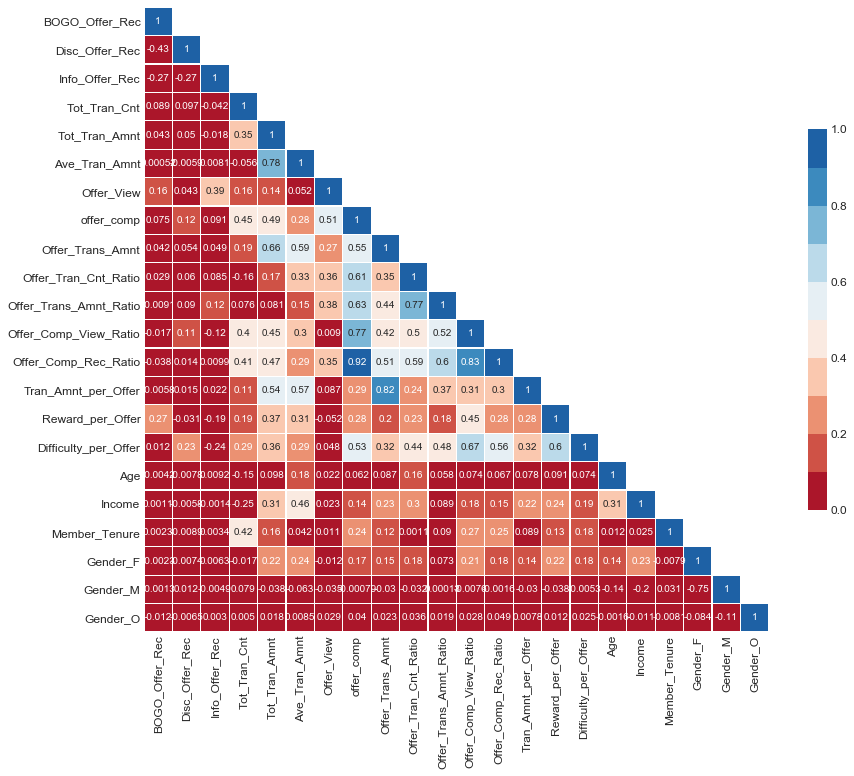

In [32]:
Correlation_Plot(X,14)

### Important Features

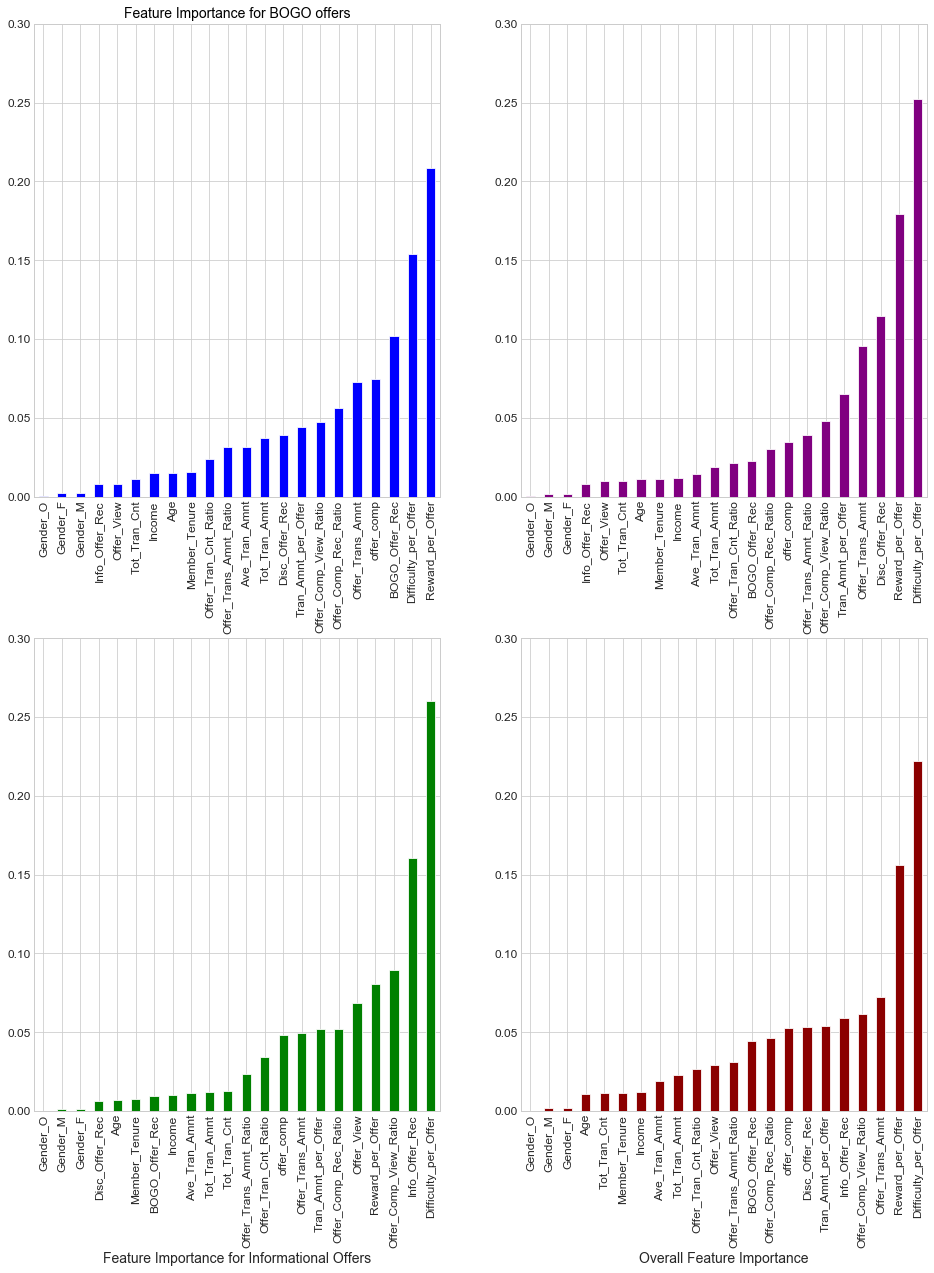

In [33]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 20))

# Feature Importance for BOGO offers
pd.Series(clf.estimators_[0].feature_importances_,
          index = x_train.columns).sort_values(ascending = True).plot.bar(color='Blue', rot=90, ax=ax[0,0])
_ = ax[0,0].set_title('Feature Importance for BOGO offers')
_ = ax[0,0].set_ylim([0, 0.3])
_ = ax[0,0].set_xlabel('Feature Importance')

# Feature Importance for Discount Offers
pd.Series(clf.estimators_[1].feature_importances_, 
          index = x_train.columns).sort_values(ascending = True).plot.bar(color='Purple', rot=90, ax=ax[0,1])
_ = ax[0,1].set_ylim([0, 0.3])
_ = ax[0,1].set_xlabel('Feature Importance for Discount Offers')

# Feature Importance for Informational Offers
pd.Series(clf.estimators_[2].feature_importances_, 
          index = x_train.columns).sort_values(ascending = True).plot.bar(color='Green', rot=90, ax=ax[1,0])
_ = ax[1,0].set_ylim([0, 0.3])
_ = ax[1,0].set_xlabel('Feature Importance for Informational Offers')

# Overall Feature Importance
Feature_Importance = [] 
for mod in clf.estimators_:
    Feature_Importance.append(mod.feature_importances_)
    
pd.Series(np.mean(Feature_Importance, axis=0),
          index = x_train.columns).sort_values(ascending = True).plot.bar(color='DarkRed', rot=90, ax=ax[1,1])
_ = ax[1,1].set_ylim([0, 0.3])
_ = ax[1,1].set_xlabel('Overall Feature Importance')

plt.subplots_adjust(hspace=0.3)

It seems that `Reward_per_Offer` and `Difficulty_per_Offer` are the most important features across the board. How is each feature different among the three offer types?

### Feature Difference by Offer Combination

To have plots for this part. We need to calulate `transactions amount without any offers` and `The number of transaction without any offers`.

In [34]:
# Transactions amount without any offers
user_data['Tran_Amnt_No_Offer'] = user_data['Tot_Tran_Amnt']- user_data['Offer_Trans_Amnt']
# The number of transaction without any offers
user_data['Trans_Cnt_No_Offer'] = user_data['Tot_Tran_Cnt']- user_data['offer_comp']
# Converting to integers
user_data[['BOGO_offer','Disc_offer','Info_offer']] = user_data[['BOGO_offer','Disc_offer','Info_offer']].astype(int)

The following function helps with various plotting.

In [35]:
def Mean_by_Offer_Type (which_columns):    
    col = which_columns[0]
    Data = user_data.groupby(['BOGO_offer','Disc_offer','Info_offer'])[col].mean().reset_index()
    for col in which_columns[1:]:
        curr = user_data.groupby(['BOGO_offer','Disc_offer','Info_offer'])[col].mean().reset_index()
        Data = Data.merge(curr, on =['BOGO_offer','Disc_offer','Info_offer'])
    return Data

#### Metric Average of Offer Type Combinations plots


In the following tables and plots, <font color='blue'>(BOGO Offer, Discount Offer, Informational Offer)</font>  shows that what offer has been used. For example, (1,1,0) means people who respond to <font color='blue'>BOGO Offers</font> and <font color='blue'>Discount Offers</font> but not <font color='blue'>Informational Offers</font>.

In [36]:
Column_List = ['Offer_Tran_Cnt_Ratio', 'Offer_Trans_Amnt_Ratio',
             'Offer_Comp_View_Ratio', 'Offer_Comp_Rec_Ratio']
Table1 = Mean_by_Offer_Type (Column_List).set_index(['BOGO_offer','Disc_offer','Info_offer'])
Table1

Offer_Tran_Cnt_Ratio  \
BOGO_offer Disc_offer Info_offer                         
0          0          0                       0.000000   
                      1                       0.210972   
           1          0                       0.238329   
                      1                       0.311443   
1          0          0                       0.272829   
                      1                       0.354187   
           1          0                       0.384003   
                      1                       0.413975   

                                  Offer_Trans_Amnt_Ratio  \
BOGO_offer Disc_offer Info_offer                           
0          0          0                         0.000000   
                      1                         0.313516   
           1          0                         0.403308   
                      1                         0.523864   
1          0          0                         0.353967   
                      1                         0.511131   
           1          0                         0.454226   
                      1                         0.551143   

                                  Offer_Comp_View_Ratio  Offer_Comp_Rec_Ratio  
BOGO_offer Disc_offer Info_offer                                               
0          0          0                        0.000000              0.000000  
                      1                        0.280681              0.289194  
           1          0                        0.524856              0.360440  
                      1                        0.536360              0.588828  
1          0          0                        0.551579              0.378204  
                      1                        0.550082              0.605572  
           1          0                        0.758921              0.647038  
                      1                        0.683811              0.792367

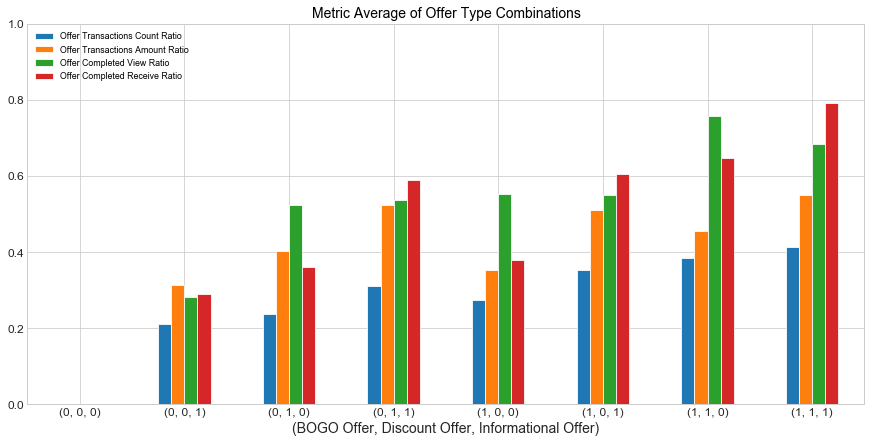

In [37]:
Table1.plot.bar(figsize=(15,7), rot = 0)
_ = plt.title('Metric Average of Offer Type Combinations')
_ = plt.legend(('Offer Transactions Count Ratio', 'Offer Transactions Amount Ratio',
            'Offer Completed View Ratio', 'Offer Completed Receive Ratio'), loc='upper left')
_ = plt.xlabel('(BOGO Offer, Discount Offer, Informational Offer)')
_ = plt.ylim(0,1)

In [38]:
Column_List = ['offer_comp', 'Tot_Tran_Cnt', 'Trans_Cnt_No_Offer', 
             'Tot_Rewards_Rec', 'Reward_per_Offer','Difficulty_per_Offer']
Table2 = Mean_by_Offer_Type (Column_List).set_index(['BOGO_offer','Disc_offer','Info_offer'])
Table2

offer_comp  Tot_Tran_Cnt  \
BOGO_offer Disc_offer Info_offer                             
0          0          0             0.000000      4.477916   
                      1             1.194362      7.511128   
           1          0             1.490520      9.024579   
                      1             2.675868     10.866719   
1          0          0             1.533952      7.733757   
                      1             2.757937      9.548611   
           1          0             2.943457      9.863974   
                      1             3.950590     11.294985   

                                  Trans_Cnt_No_Offer  Tot_Rewards_Rec  \
BOGO_offer Disc_offer Info_offer                                        
0          0          0                     4.477916         1.524814   
                      1                     6.316766         1.637982   
           1          0                     7.534059         7.187500   
                      1                     8.190852         6.658517   
1          0          0                     6.199805        15.763068   
                      1                     6.790675        14.901786   
           1          0                     6.920517        18.608078   
                      1                     7.344395        16.615044   

                                  Reward_per_Offer  Difficulty_per_Offer  
BOGO_offer Disc_offer Info_offer                                          
0          0          0                   0.000000              0.000000  
                      1                   1.459266              0.000000  
           1          0                   5.192008              9.516057  
                      1                   2.548659              5.218809  
1          0          0                  10.703923              7.281666  
                      1                   5.468373              3.961052  
           1          0                   6.509651              8.819955  
                      1                   4.239572              6.240007

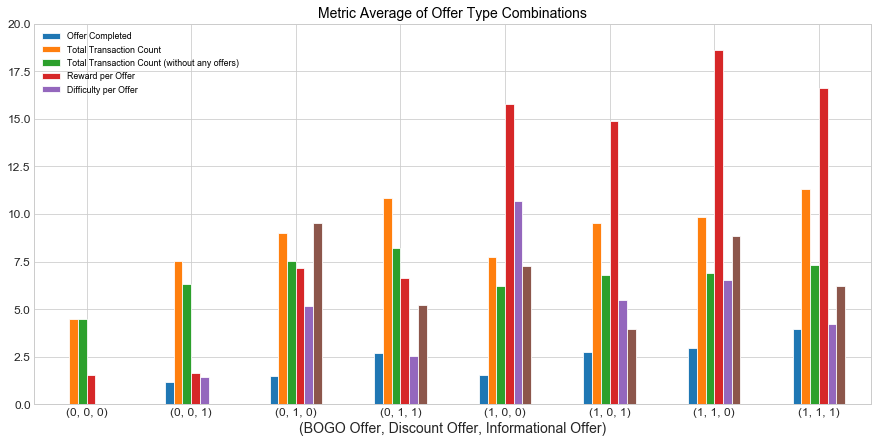

In [39]:
Table2.plot.bar(figsize=(15,7), rot = 0)
_ = plt.title('Metric Average of Offer Type Combinations')
_ = plt.legend(('Offer Completed', 'Total Transaction Count',
            'Total Transaction Count (without any offers)', 'Reward per Offer',
           'Difficulty per Offer'), loc='upper left')
_ = plt.xlabel('(BOGO Offer, Discount Offer, Informational Offer)')
_ = plt.ylim(0,20)

In [40]:
Column_List = [ 'Tot_Tran_Amnt',  'Offer_Trans_Amnt', 
             'Tran_Amnt_per_Offer','Ave_Tran_Amnt', 'Tran_Amnt_No_Offer']
Table3 = Mean_by_Offer_Type (Column_List).set_index(['BOGO_offer','Disc_offer','Info_offer'])
Table3

Tot_Tran_Amnt  Offer_Trans_Amnt  \
BOGO_offer Disc_offer Info_offer                                    
0          0          0               26.226658          0.000000   
                      1               46.729889         14.421313   
           1          0               95.118409         29.533666   
                      1              115.747248         52.064874   
1          0          0              120.001519         32.787132   
                      1              146.231647         66.400060   
           1          0              175.063706         66.758782   
                      1              187.489034         93.155922   

                                  Tran_Amnt_per_Offer  Ave_Tran_Amnt  \
BOGO_offer Disc_offer Info_offer                                       
0          0          0                      0.000000       6.167414   
                      1                     11.499748       7.247821   
           1          0                     19.332848      13.327519   
                      1                     18.934850      12.591349   
1          0          0                     21.472926      17.600939   
                      1                     23.504613      16.731759   
           1          0                     22.287325      19.720937   
                      1                     23.332935      17.929987   

                                  Tran_Amnt_No_Offer  
BOGO_offer Disc_offer Info_offer                      
0          0          0                    26.226658  
                      1                    32.308576  
           1          0                    65.584744  
                      1                    63.682374  
1          0          0                    87.214387  
                      1                    79.831587  
           1          0                   108.304924  
                      1                    94.333112

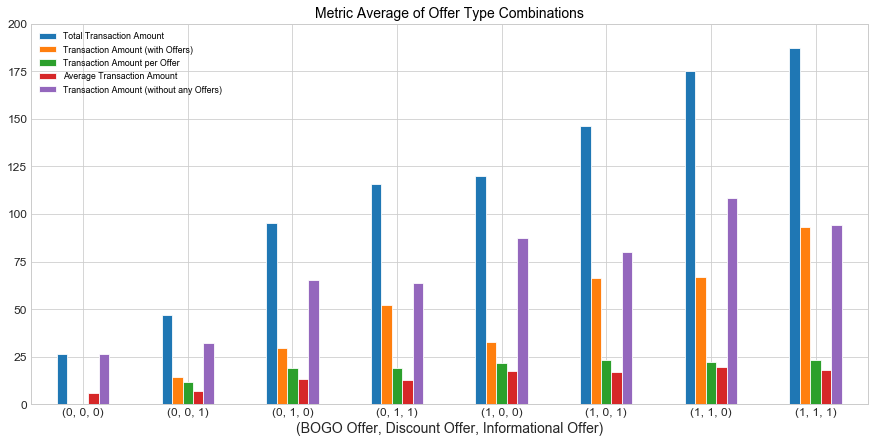

In [41]:
Table3.plot.bar(figsize=(15,7), rot = 0)
_ = plt.title('Metric Average of Offer Type Combinations')
_ = plt.legend(('Total Transaction Amount', 'Transaction Amount (with Offers)',
            'Transaction Amount per Offer', 'Average Transaction Amount',
           'Transaction Amount (without any Offers)'), loc='upper left')
_ = plt.xlabel('(BOGO Offer, Discount Offer, Informational Offer)')
_ = plt.ylim(0,200)

* According to the plots the customers who have taken advantage of all three offer types not only spend the most with offers but also have the highest total transaction amount. In other words, a higher amount of incentivization leads to spending more money.

* The BOGO offer is the leading offer in terms of having a higher total transaction amount than discount and informational offers. Besides, customers tend to spend more than half of the total transaction amount without offers while using BOGO and discount offers.

We would like to know how the overall offer completion rate, transaction amount ratio motivated by an offer, and reward per offer affected by the user demographics.

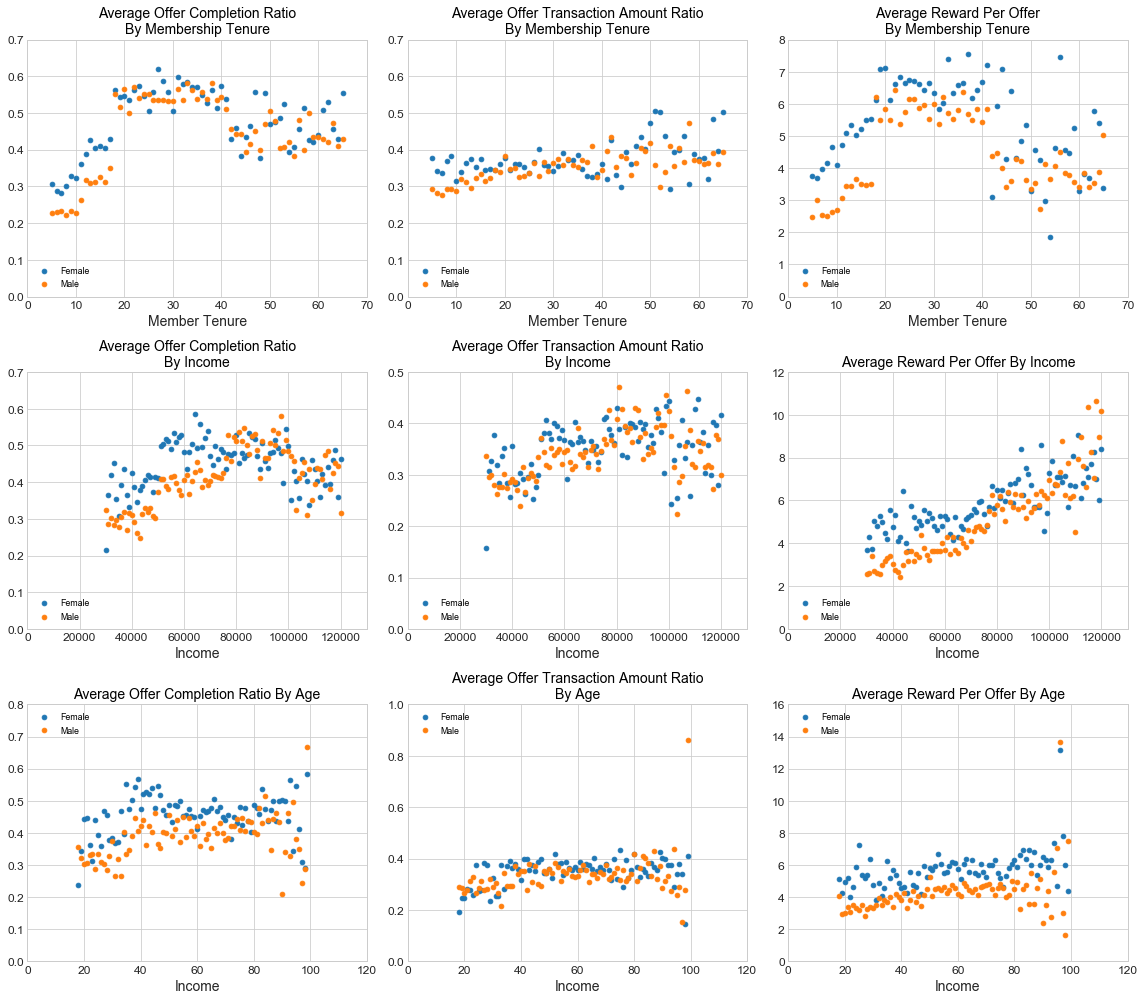

In [42]:
_ = plt.figure(figsize=(16,14))

# Average Offer Completion RatioBy Membership Tenure
_ = plt.subplot(331)
female_avg = user_data[user_data['Gender_F']==1].groupby('Member_Tenure').mean()['Offer_Comp_Rec_Ratio']
male_avg = user_data[user_data['Gender_M']==1].groupby('Member_Tenure').mean()['Offer_Comp_Rec_Ratio']
_ = plt.scatter(female_avg.index, female_avg, label='Female')
_ = plt.scatter(male_avg.index, male_avg, label='Male')
_ = plt.xlim(0,70)
_ = plt.ylim(0,0.7)
_ = plt.xlabel('Member Tenure')
_ = plt.title('Average Offer Completion Ratio\nBy Membership Tenure')
_ = plt.legend(loc='lower left')

# Average Offer Transaction Amount Ratio By Membership Tenure
_ = plt.subplot(332)
female_avg = user_data[user_data['Gender_F']==1].groupby('Member_Tenure')['Offer_Trans_Amnt_Ratio'].mean()
male_avg = user_data[user_data['Gender_M']==1].groupby('Member_Tenure')['Offer_Trans_Amnt_Ratio'].mean()
_ = plt.scatter(female_avg.index, female_avg, label='Female')
_ = plt.scatter(male_avg.index, male_avg, label='Male')
_ = plt.xlim(0,70)
_ = plt.ylim(0,0.7)
_ = plt.xlabel('Member Tenure')
_ = plt.title('Average Offer Transaction Amount Ratio\nBy Membership Tenure')
_ = plt.legend(loc='lower left')

# Average Reward Per Offer By Membership Tenure
_ = plt.subplot(333)
female_avg = user_data[user_data['Gender_F']==1].groupby('Member_Tenure')['Reward_per_Offer'].mean()
male_avg = user_data[user_data['Gender_M']==1].groupby('Member_Tenure')['Reward_per_Offer'].mean()
_ = plt.scatter(female_avg.index, female_avg, label='Female')
_ = plt.scatter(male_avg.index, male_avg, label='Male')
_ = plt.xlim(0,70)
_ = plt.ylim(0,8)
_ = plt.xlabel('Member Tenure')
_ = plt.title('Average Reward Per Offer\nBy Membership Tenure')
_ = plt.legend(loc='lower left')

# Average Offer Completion Ratio By Income
_ = plt.subplot(334)
female_avg = user_data[user_data['Gender_F']==1].groupby('Income').mean()['Offer_Comp_Rec_Ratio']
male_avg = user_data[user_data['Gender_M']==1].groupby('Income').mean()['Offer_Comp_Rec_Ratio']
_ = plt.scatter(female_avg.index, female_avg, label='Female')
_ = plt.scatter(male_avg.index, male_avg, label='Male')
_ = plt.xlim(0,130000)
_ = plt.ylim(0,0.7)
_ = plt.xlabel('Income')
_ = plt.title('Average Offer Completion Ratio\nBy Income')
_ = plt.legend(loc='lower left')

# Average Offer Transaction Amount Ratio By Income
_ = plt.subplot(335)
female_avg = user_data[user_data['Gender_F']==1].groupby('Income')['Offer_Trans_Amnt_Ratio'].mean()
male_avg = user_data[user_data['Gender_M']==1].groupby('Income')['Offer_Trans_Amnt_Ratio'].mean()
_ = plt.scatter(female_avg.index, female_avg, label='Female')
_ = plt.scatter(male_avg.index, male_avg, label='Male')
_ = plt.xlim(0,130000)
_ = plt.ylim(0,0.5)
_ = plt.xlabel('Income')
_ = plt.title('Average Offer Transaction Amount Ratio\nBy Income')
_ = plt.legend(loc='lower left')

# Average Reward Per Offer By Income
_ = plt.subplot(336)
female_avg = user_data[user_data['Gender_F']==1].groupby('Income')['Reward_per_Offer'].mean()
male_avg = user_data[user_data['Gender_M']==1].groupby('Income')['Reward_per_Offer'].mean()
_ = plt.scatter(female_avg.index, female_avg, label='Female')
_ = plt.scatter(male_avg.index, male_avg, label='Male')
_ = plt.xlim(0,130000)
_ = plt.ylim(0,12)
_ = plt.xlabel('Income')
_ = plt.title('Average Reward Per Offer By Income')
_ = plt.legend(loc='lower left')

# Average Offer Completion Ratio By Age
_ = plt.subplot(337)
female_avg = user_data[user_data['Gender_F']==1].groupby('Age').mean()['Offer_Comp_Rec_Ratio']
male_avg = user_data[user_data['Gender_M']==1].groupby('Age').mean()['Offer_Comp_Rec_Ratio']
_ = plt.scatter(female_avg.index, female_avg, label='Female')
_ = plt.scatter(male_avg.index, male_avg, label='Male')
_ = plt.xlim(0,120)
_ = plt.ylim(0,0.8)
_ = plt.xlabel('Income')
_ = plt.title('Average Offer Completion Ratio By Age')
_ = plt.legend(loc='upper left')

# Average Offer Transaction Amount Ratio By Age
_ = plt.subplot(338)
female_avg = user_data[user_data['Gender_F']==1].groupby('Age')['Offer_Trans_Amnt_Ratio'].mean()
male_avg = user_data[user_data['Gender_M']==1].groupby('Age')['Offer_Trans_Amnt_Ratio'].mean()
_ = plt.scatter(female_avg.index, female_avg, label='Female')
_ = plt.scatter(male_avg.index, male_avg, label='Male')
_ = plt.xlim(0,120)
_ = plt.ylim(0,1)
_ = plt.xlabel('Income')
_ = plt.title('Average Offer Transaction Amount Ratio\nBy Age')
_ = plt.legend(loc='upper left')

# Average Reward Per Offer By Age
_ = plt.subplot(339)
female_avg = user_data[user_data['Gender_F']==1].groupby('Age')['Reward_per_Offer'].mean()
male_avg = user_data[user_data['Gender_M']==1].groupby('Age')['Reward_per_Offer'].mean()
_ = plt.scatter(female_avg.index, female_avg, label='Female')
_ = plt.scatter(male_avg.index, male_avg, label='Male')
_ = plt.xlim(0,120)
_ = plt.ylim(0,16)
_ = plt.xlabel('Income')
_ = plt.title('Average Reward Per Offer By Age')
_ = plt.legend(loc='upper left')

_ = plt.tight_layout()

Key takeaways from the scatter plots above:
1. Offer completion rate grows steadily as the tenure increases in the beginning, and is at its peak when the user tenures of both gender are between 20-30 months, then it declines a bit as the tenure increase, especially for male customers. In reality, the offer conversion rate would grow as the new users get used to the app and start utilizing the benefits more oftenm. After that phase, the conversion rate becomes plateaued.
2. Offer completion rate also seem to have a positive linear relationship with income before income hits 80000. After that it starts to drop as the income increases. Customers are more inclined to use offers when their incomes are below a certain level. After surpassing that income level, the effect of using an offer on motivating transactions decreases.
3. In general, female customers have a higher offer completion rate than male customers, especially in the early tenure and lower income bucket.
4. Average rewards per offer grows steadily as income increases.
5. Female customers also tend to earn higher rewards per offer across almost the whole spectrum of tenure, age and income. It is partly because females have a higher offer completion rate than males. It also implicates that female users are more prone to use BOGO or discount offers to earn rewards, since informational offer do not give out rewards.

Next I want to check whether different demographic groups respond differently to the three offer types.

In [43]:
user_data['BOGO_Conv_Rate'] = user_data['BOGO_comp']/user_data['BOGO_Offer_Rec']
user_data['Disc_Conv_Rate'] = user_data['Disc_comp']/user_data['Disc_Offer_Rec']
user_data['Info_Conv_Rate'] = user_data['Info_comp']/user_data['Info_Offer_Rec']

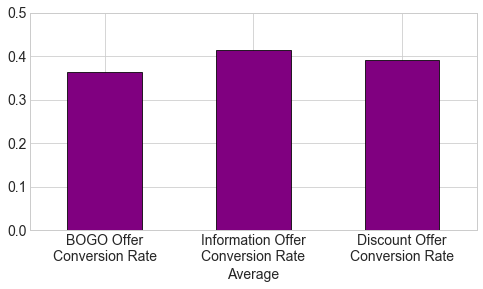

In [44]:
Temp = user_data[['BOGO_Conv_Rate', 'Disc_Conv_Rate','Info_Conv_Rate']].mean()
Temp.plot.bar(figsize=(8,4), color= 'Purple', edgecolor='k', fontsize = 14,rot=0)
_ = plt.ylim([0, 0.5])
_ = plt.xticks(np.arange(3),('BOGO Offer\nConversion Rate', 
                         'Information Offer\nConversion Rate',
                         'Discount Offer\nConversion Rate'))
_ = plt.xlabel('Average')

Discount offer has a slightly higher average conversion rate than the other two offer types, making it the most effective offer among three.

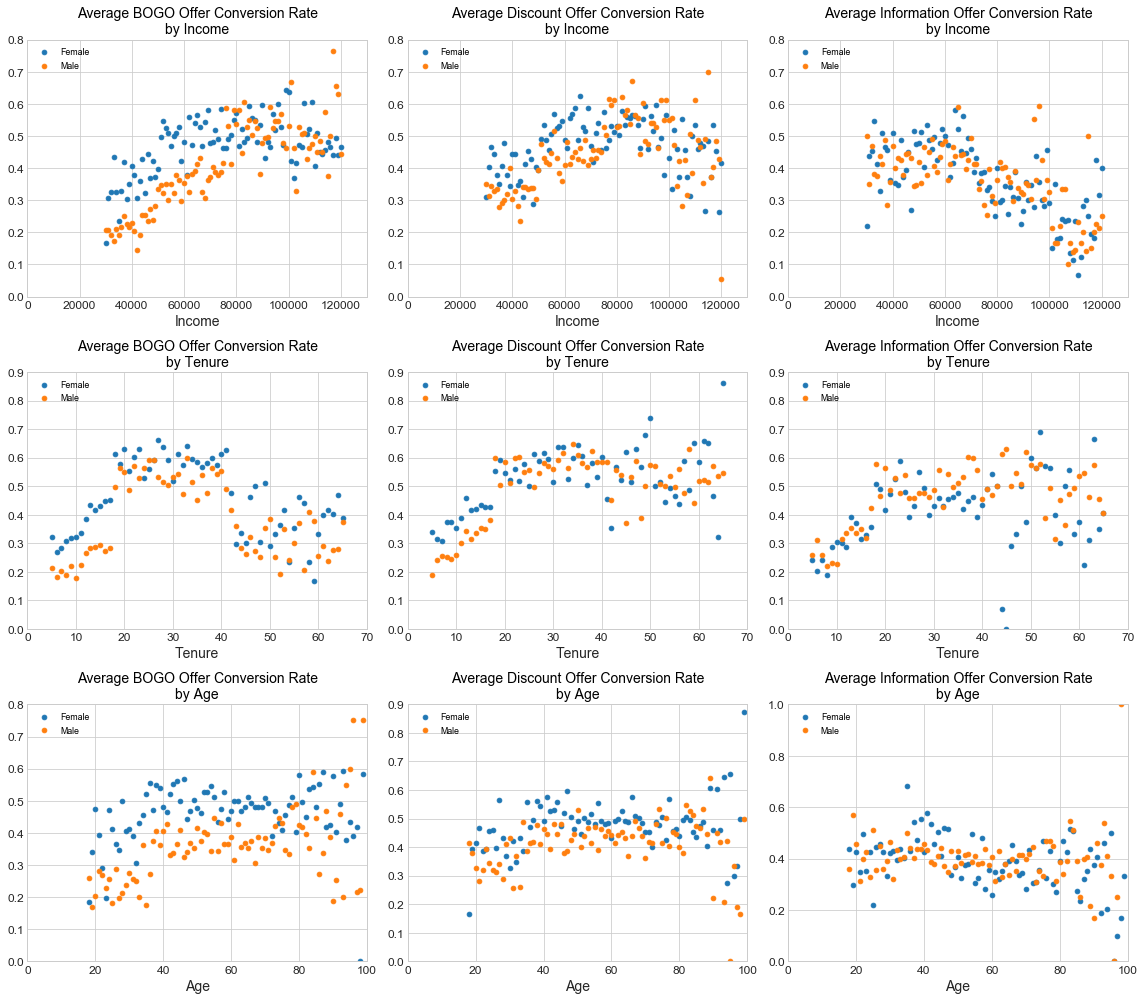

In [45]:
_ = plt.figure(figsize=(16,14))

# Average BOGO Offer Conversion Rate by Income
_ = plt.subplot(331)
female_avg = user_data[user_data['Gender_F']==1].groupby('Income')['BOGO_Conv_Rate'].mean()
male_avg = user_data[user_data['Gender_M']==1].groupby('Income')['BOGO_Conv_Rate'].mean()
_ = plt.scatter(female_avg.index, female_avg, label='Female')
_ = plt.scatter(male_avg.index, male_avg, label='Male')
_ = plt.xlim(0,130000)
_ = plt.ylim(0,0.8)
_ = plt.xlabel('Income')
_ = plt.title('Average BOGO Offer Conversion Rate\nby Income')
_ = plt.legend(loc='upper left')

# Average Discount Offer Conversion Rate by Income
_ = plt.subplot(332)
female_avg = user_data[user_data['Gender_F']==1].groupby('Income')['Disc_Conv_Rate'].mean()
male_avg = user_data[user_data['Gender_M']==1].groupby('Income')['Disc_Conv_Rate'].mean()
_ = plt.scatter(female_avg.index, female_avg, label='Female')
_ = plt.scatter(male_avg.index, male_avg, label='Male')
_ = plt.xlim(0,130000)
_ = plt.ylim(0,0.8)
_ = plt.xlabel('Income')
_ = plt.title('Average Discount Offer Conversion Rate\nby Income')
_ = plt.legend(loc='upper left')

# Average Information Offer Conversion Rate by Income
_ = plt.subplot(333)
female_avg = user_data[user_data['Gender_F']==1].groupby('Income')['Info_Conv_Rate'].mean()
male_avg = user_data[user_data['Gender_M']==1].groupby('Income')['Info_Conv_Rate'].mean()
_ = plt.scatter(female_avg.index, female_avg, label='Female')
_ = plt.scatter(male_avg.index, male_avg, label='Male')
_ = plt.xlim(0,130000)
_ = plt.ylim(0,0.8)
_ = plt.xlabel('Income')
_ = plt.title('Average Information Offer Conversion Rate\nby Income')
_ = plt.legend(loc='upper left')

# Average BOGO Offer Conversion Rate by Tenure
_ = plt.subplot(334)
female_avg = user_data[user_data['Gender_F']==1].groupby('Member_Tenure')['BOGO_Conv_Rate'].mean()
male_avg = user_data[user_data['Gender_M']==1].groupby('Member_Tenure')['BOGO_Conv_Rate'].mean()
_ = plt.scatter(female_avg.index, female_avg, label='Female')
_ = plt.scatter(male_avg.index, male_avg, label='Male')
_ = plt.xlim(0,70)
_ = plt.ylim(0,0.9)
_ = plt.xlabel('Tenure')
_ = plt.title('Average BOGO Offer Conversion Rate\nby Tenure')
_ = plt.legend(loc='upper left')

# Average Discount Offer Conversion Rate by Tenure
_ = plt.subplot(335)
female_avg = user_data[user_data['Gender_F']==1].groupby('Member_Tenure')['Disc_Conv_Rate'].mean()
male_avg = user_data[user_data['Gender_M']==1].groupby('Member_Tenure')['Disc_Conv_Rate'].mean()
_ = plt.scatter(female_avg.index, female_avg, label='Female')
_ = plt.scatter(male_avg.index, male_avg, label='Male')
_ = plt.xlim(0,70)
_ = plt.ylim(0,0.9)
_ = plt.xlabel('Tenure')
_ = plt.title('Average Discount Offer Conversion Rate\nby Tenure')
_ = plt.legend(loc='upper left')

# Average Information Offer Conversion Rate by Tenure
_ = plt.subplot(336)
female_avg = user_data[user_data['Gender_F']==1].groupby('Member_Tenure')['Info_Conv_Rate'].mean()
male_avg = user_data[user_data['Gender_M']==1].groupby('Member_Tenure')['Info_Conv_Rate'].mean()
_ = plt.scatter(female_avg.index, female_avg, label='Female')
_ = plt.scatter(male_avg.index, male_avg, label='Male')
_ = plt.xlim(0,70)
_ = plt.ylim(0,0.9)
_ = plt.xlabel('Tenure')
_ = plt.title('Average Information Offer Conversion Rate\nby Tenure')
_ = plt.legend(loc='upper left')

# Average BOGO Offer Conversion Rate by Age
_ = plt.subplot(337)
female_avg = user_data[user_data['Gender_F']==1].groupby('Age')['BOGO_Conv_Rate'].mean()
male_avg = user_data[user_data['Gender_M']==1].groupby('Age')['BOGO_Conv_Rate'].mean()
_ = plt.scatter(female_avg.index, female_avg, label='Female')
_ = plt.scatter(male_avg.index, male_avg, label='Male')
_ = plt.xlim(0,100)
_ = plt.ylim(0,0.8)
_ = plt.xlabel('Age')
_ = plt.title('Average BOGO Offer Conversion Rate\nby Age')
_ = plt.legend(loc='upper left')

# Average Discount Offer Conversion Rate by Age
_ = plt.subplot(338)
female_avg = user_data[user_data['Gender_F']==1].groupby('Age')['Disc_Conv_Rate'].mean()
male_avg = user_data[user_data['Gender_M']==1].groupby('Age')['Disc_Conv_Rate'].mean()
_ = plt.scatter(female_avg.index, female_avg, label='Female')
_ = plt.scatter(male_avg.index, male_avg, label='Male')
_ = plt.xlim(0,100)
_ = plt.ylim(0,0.9)
_ = plt.xlabel('Age')
_ = plt.title('Average Discount Offer Conversion Rate\nby Age')
_ = plt.legend(loc='upper left')

# Average Information Offer Conversion Rate by Age
_ = plt.subplot(339)
female_avg = user_data[user_data['Gender_F']==1].groupby('Age')['Info_Conv_Rate'].mean()
male_avg = user_data[user_data['Gender_M']==1].groupby('Age')['Info_Conv_Rate'].mean()
_ = plt.scatter(female_avg.index, female_avg, label='Female')
_ = plt.scatter(male_avg.index, male_avg, label='Male')
_ = plt.xlim(0,100)
_ = plt.ylim(0,1)
_ = plt.xlabel('Age')
_ = plt.title('Average Information Offer Conversion Rate\nby Age')
_ = plt.legend(loc='upper left')

_ = plt.tight_layout()

It can be seen from the plots that:

* The age has an insignificant effect on the offer conversion rate while both Income and tenure seem to have a noticeable impact on the offer conversion rate.

* A higher conversion rate for BOGO offer from Female customers (different ages) can be discerned.

* Informational offers have been more efficient through conversion rate for male customers. 

* BOGO offer conversion rate reaches its peak after 20 to 30 months from the start of membership and then plummets.

* Discount offers conversion rate has been the subject of stable growth as the tenure increases.

### Predicting the most suitable offer type for a customer

The model can predict multiple offer types for a given customer, and then sort the recommendations based on a higher probability of conversion. Then, we can find the most suitable offer for the customer.

In [46]:
def Best_Offer (ID, Model=clf):
    # Input: ID
    # all avialable offers
    Offers = ['bogo','discount','informational']
    # the probability for given user(s)
    Predicted_Prop = clf.predict_proba(X.loc[ID])
    # Best offers for given user(s)
    Class_Predicted_Prop = clf.predict(X.loc[ID])
    # Prediccted probility for each offer type    
    Offer_Predicted_Prop = [[Predicted_Prop[c][i][1] for c in range(len(Offers)) ] for i in range(len(ID))]
    Offer_Predicted_Prop = np.array(Offer_Predicted_Prop)
    # Best_Offer_List
    Best_Offer_List = []
    for user in range(len(Offer_Predicted_Prop)):
        if Class_Predicted_Prop[user].sum()>0:
            # the index where predicted offer = 1
            Predicted_Class_ID = np.argwhere(Class_Predicted_Prop[user]==1).flatten()
            Prop_ID_Sort = np.argsort(-Offer_Predicted_Prop[user])
            # sorting probability in descending order to pick the most suitable one
            Best_Index = [i for i in Prop_ID_Sort if i in Predicted_Class_ID]
            Best_Offer_List.append([Offers[i] for i in Best_Index])
        else:
            Best_Offer_List.append('no offer is recommended for the user')
            
    return Best_Offer_List

For example consider a random list of ten customers. We have,

In [47]:
n=10
ID = np.random.choice(x_test.index, n)
pd.DataFrame(data={'Customers': ID, 'Most Suitable Offers': Best_Offer(ID)})

Customers                  Most Suitable Offers
0  a4ecd1ebb16a4800bdbf57aaf0144078  no offer is recommended for the user
1  5519acfc31b94c0e84f78c71bd993b77                 [informational, bogo]
2  a2ac56c8f36448a982009510d0447891                       [informational]
3  4e10162162e04db9a8762949c7239d04                            [discount]
4  54e8ee4932f94d1aa18eecf7c15ef616  no offer is recommended for the user
5  ae56c4d76ac84a639a31693086044dd9                                [bogo]
6  48573df4fa094a87838a22bd069efbef  no offer is recommended for the user
7  45f7001a234a41d3b55d24f40cdc1f0b                                [bogo]
8  4ed81a6649494adf87bd8a910521e845                      [bogo, discount]
9  18d0ef3f15b5463aba2717969f6629a7                            [discount]